## Burger's equation: Two-step Method

In [1]:
# Import packages
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics.pairwise import polynomial_kernel
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit
from jaxopt import LBFGS
from jaxopt import GradientDescent
from functools import partial
from jax.config import config;
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')
from parameter_learning import *
from plotlib import *
from models import * 
from kernels import *
from data_loader_Burgers import *
from loss import *
from utils import *
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
config.update("jax_enable_x64", True)

In [2]:
# 2-step dictionary
keys = ['optim_sgm_u','optim_nugget_u','rkhs_u','optim_sgm_P','optim_nugget_P','nugget_P', 'rkhs_P_train', 'rkhs_P_train', 'f_gh_tr_pred']
two_step_dict = dict.fromkeys(keys)

### > Step 1: Learning $u's$

In [3]:
# Learn alphas and hyperparms
optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_tr, U_tr, N_tr)

In [4]:
# Save true values to be used in one-step 
two_step_dict['optim_sgm_u'] = optim_sgm_u 
two_step_dict['optim_nugget_u'] = optim_nugget_u 
optim_sgm_u, optim_nugget_u 

(array([2.1034354 , 5.35961342]), array([1.43844989e-11, 8.85866790e-14]))

In [5]:
# Predict using interpolant and get its gradients 
U_tr_pred, U_t_tr_pred, U_x_tr_pred, U_xx_tr_pred = predictions_Burgers_tr(X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr)
U_te_pred, U_t_te_pred, U_x_te_pred, U_xx_te_pred = predictions_Burgers_te(X_te, X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr, N_te)
U_gh_tr_pred, U_t_gh_tr_pred, U_x_gh_tr_pred, U_xx_gh_tr_pred = predictions_Burgers_te(X_gh_tr, X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr, N_gh_tr)

In [6]:
# Save true values to warm up the onepfive method
np.save('data/U_tr_pred.npy', U_tr_pred)
np.save('data/U_te_pred.npy', U_te_pred)
np.save('data/U_gh_tr_pred.npy', U_gh_tr_pred)
# Save true gradients for comparing later  
np.save('data/U_t_tr.npy', U_t_tr) 
np.save('data/U_x_tr.npy', U_x_tr) 
np.save('data/U_xx_tr.npy', U_xx_tr) 

# Save gradients for one step method
# U_x
np.save('data/U_x_tr_pred.npy', U_x_tr_pred)
np.save('data/U_x_gh_tr_pred.npy', U_x_gh_tr_pred)
np.save('data/U_x_te_pred.npy', U_x_te_pred)
# U_xx
np.save('data/U_xx_tr_pred.npy', U_xx_tr_pred)
np.save('data/U_xx_gh_tr_pred.npy', U_xx_gh_tr_pred)
np.save('data/U_xx_te_pred.npy', U_xx_te_pred)

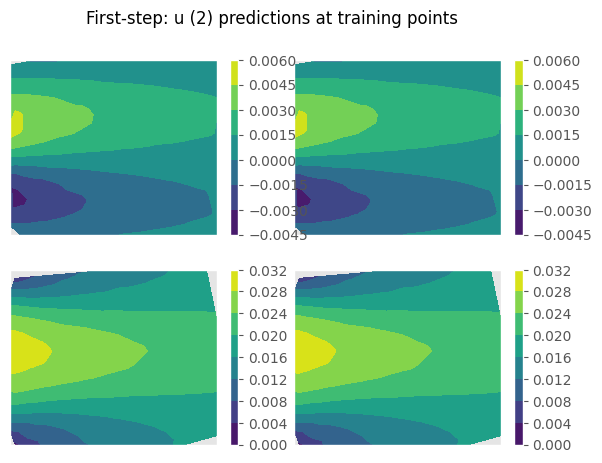

In [7]:
# Plot: u's at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

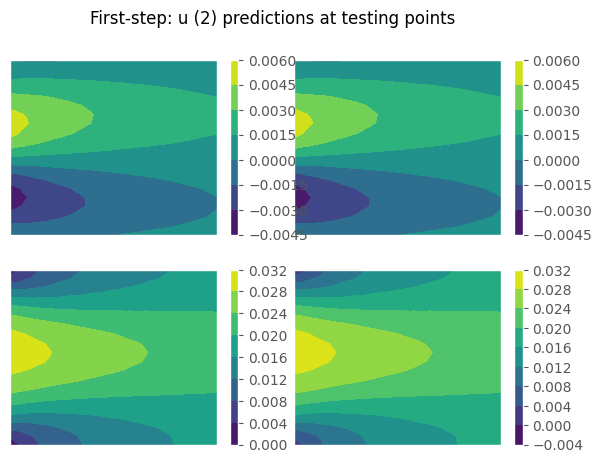

In [8]:
# Plot: u's at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [9]:
# NMSEs: u's at tr and te points
print('Normalized MSEs between u and u_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(U_tr[:,i], U_tr_pred[:,i])
    n_mse_test = rel_mse(U_te[:,i], U_te_pred[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u and u_pred for 2 functions
m = 0 nmse_train = 7.38988015073928e-05
m = 0 nmse_test = 0.007331173677982093
m = 1 nmse_train = 0.0006213446338132947
m = 1 nmse_test = 0.007164771606525362


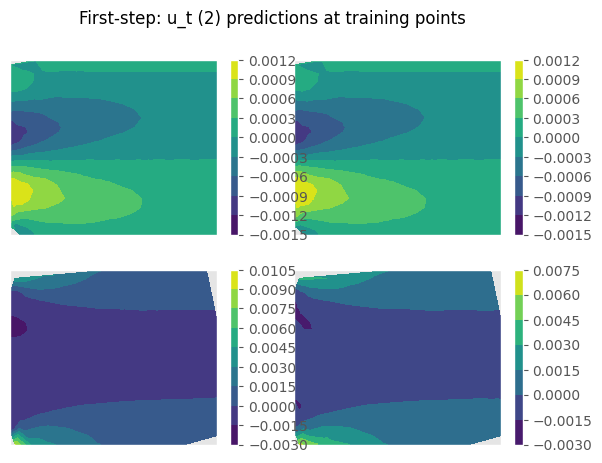

In [10]:
# Plot: u_t's at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_t ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_t_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_t_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

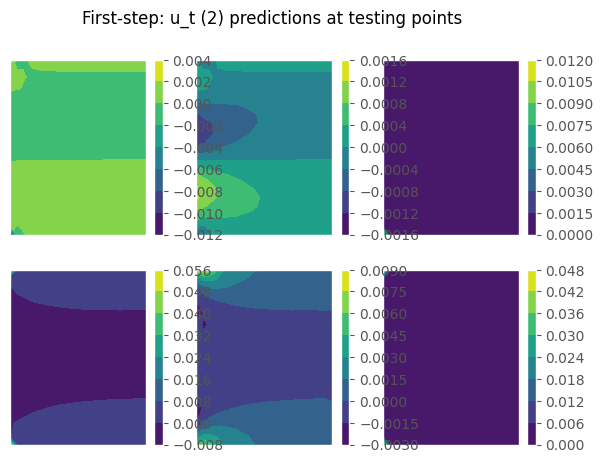

In [11]:
# Plot: u_t's at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_t ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_t_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_t_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(U_t_te[:,i]-U_t_te_pred[:,i]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [12]:
# NMSEs: u_t's at tr and te points
print('Normalized MSEs between u_t and u_t_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(U_t_tr[:,i], U_t_tr_pred[:,i])
    n_mse_test = rel_mse(U_t_te[:,i], U_t_te_pred[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u_t and u_t_pred for 2 functions
m = 0 nmse_train = 0.04309450252442794
m = 0 nmse_test = 0.8502206921972054
m = 1 nmse_train = 0.15566218720711322
m = 1 nmse_test = 0.8400066141683915


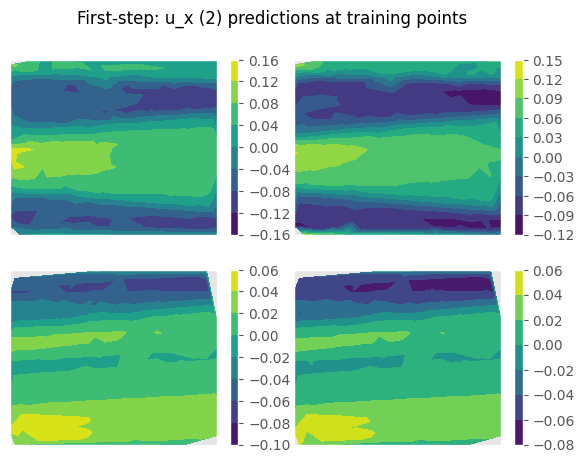

In [13]:
# Plot: u_x's at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_x_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

plt.show()

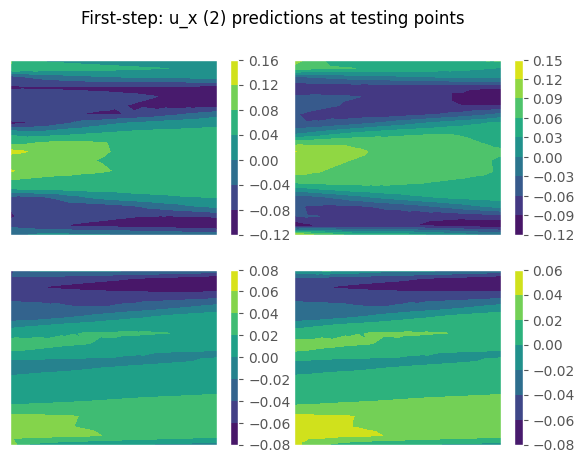

In [14]:
# Plot: u_x's at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_x ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_x_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [15]:
# NMSEs: u_x's at tr and te points
print('Normalized MSEs between u and u_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(U_x_tr[:,i], U_x_tr_pred[:,i])
    n_mse_test = rel_mse(U_x_te[:,i], U_x_te_pred[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u and u_pred for 2 functions
m = 0 nmse_train = 0.22975926010407546
m = 0 nmse_test = 0.28137867986528853
m = 1 nmse_train = 0.02919602574416072
m = 1 nmse_test = 0.11479157031697078


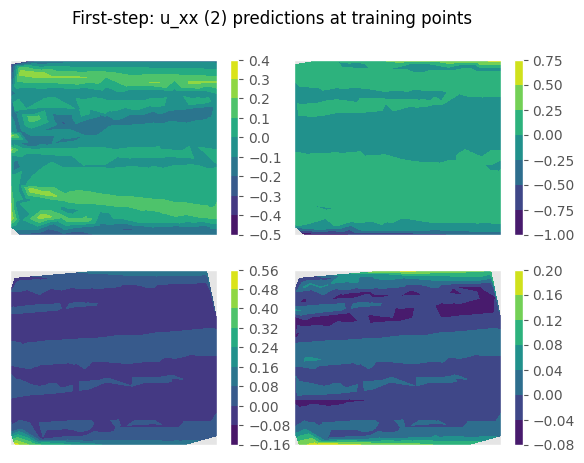

In [16]:
# Plot: u_xx's at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_xx ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_xx_tr[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], U_xx_tr_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

plt.show()

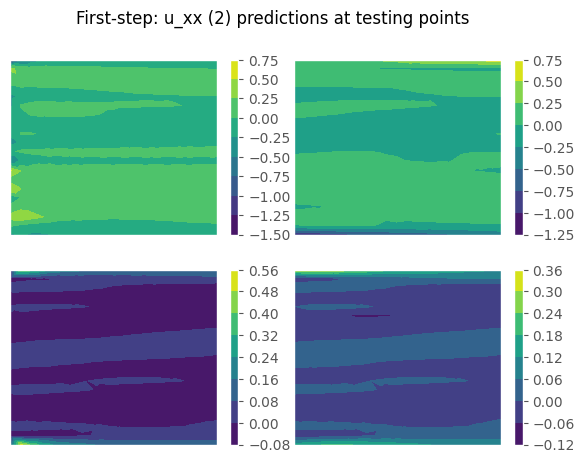

In [17]:
# Plot: u_xx's at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('First-step: u_xx ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_xx_te[:,i])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], U_xx_te_pred[:,i])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

In [18]:
# NMSEs: u_xx's at tr and te points
print('Normalized MSEs between u and u_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(U_xx_tr[:,i], U_xx_tr_pred[:,i])
    n_mse_test = rel_mse(U_xx_te[:,i], U_xx_te_pred[:,i])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between u and u_pred for 2 functions
m = 0 nmse_train = 1.340983965296271
m = 0 nmse_test = 1.3437177242742526
m = 1 nmse_train = 0.4518684356284933
m = 1 nmse_test = 0.40031976618714904


RKHSs norms squared $u^*$

In [19]:
# RKHS^2 norms of u*'s (since more regular than u's)
rkhs_u = []
G = K_2D(Gaussian2D, X_tr, X_tr, optim_sgm_u)
G = G[:,:,0] + 1e-7*jnp.diag(jnp.diag(G[:,:,0])) # I had to regularize here (?)
alphas = np.linalg.solve(G, U_tr_pred.flatten())
rkhs_u.append(np.dot(U_tr_pred.flatten(), alphas))
# Print the norm
print('RKHS^2 norm of u^*s: {}'.format(np.array(rkhs_u)))
# Save true values to be used in 1-step
two_step_dict['rkhs_u'] = rkhs_u

RKHS^2 norm of u^*s: [41794247.33485699]


> Step 2: Learning $P$

In [20]:
# Set S and f
S_tr = np.hstack((X_tr, U_tr.T.reshape(-1,1), U_x_tr_pred.T.reshape(-1,1), U_xx_tr_pred.T.reshape(-1,1))) # (m*N_tr, 5)
S_te = np.hstack((X_te, U_te.T.reshape(-1,1), U_x_te_pred.T.reshape(-1,1),U_xx_te_pred.T.reshape(-1,1))) # (m*N_te, 5)
S_gh_tr = np.hstack((X_gh_tr, U_gh_tr.T.reshape(-1,1), U_x_gh_tr_pred.T.reshape(-1,1),U_xx_gh_tr_pred.T.reshape(-1,1))) # (m*N_te, 5)

f_tr = U_t_tr.T.reshape(-1,1)
f_te = U_t_te.T.reshape(-1,1)
f_gh_tr = U_t_gh_tr.T.reshape(-1,1)

scaler_S_tr = MinMaxScaler()
S_tr_s = scaler_S_tr.fit_transform(S_tr)
S_te_s = scaler_S_tr.transform(S_te)
S_gh_tr_s = scaler_S_tr.transform(S_gh_tr)

f_tr2 = -S_tr[:,2]*S_tr[:,3] + 0.01*S_tr[:,4]
f_te2 = -S_te[:,2]*S_te[:,3] + 0.01*S_te[:,4]

In [21]:
#optim_sgm_P, optim_nugget_P = grid_search_RBF(S_tr_s,f_tr)
optim_d_P, optim_nugget_P = 2, 1e-16
# Save true values to be used in one-step
#two_step_dict['optim_sgm_P'] = optim_sgm_P
two_step_dict['optim_sgm_P'] = optim_d_P
two_step_dict['optim_nugget_P'] = optim_nugget_P

#krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_nugget_P, gamma=1/(2*(optim_sgm_P**2))) 
krr_optimal_P = KernelRidge(kernel='poly', alpha = optim_nugget_P, degree = optim_d_P) 

krr_optimal_P.fit(S_tr_s, f_tr) 
f_tr_pred = np.ndarray.flatten(krr_optimal_P.predict(S_tr_s)) 
f_te_pred = np.ndarray.flatten(krr_optimal_P.predict(S_te_s))
f_gh_tr_pred = np.ndarray.flatten(krr_optimal_P.predict(S_gh_tr_s))

In [22]:
#print('Optimal sigma of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_sgm_P,optim_nugget_P))
print('Degree for kernel of P^*:{}  Nugget of P^*: {:.2e}'.format(optim_d_P,optim_nugget_P))

Degree for kernel of P^*:2  Nugget of P^*: 1.00e-16


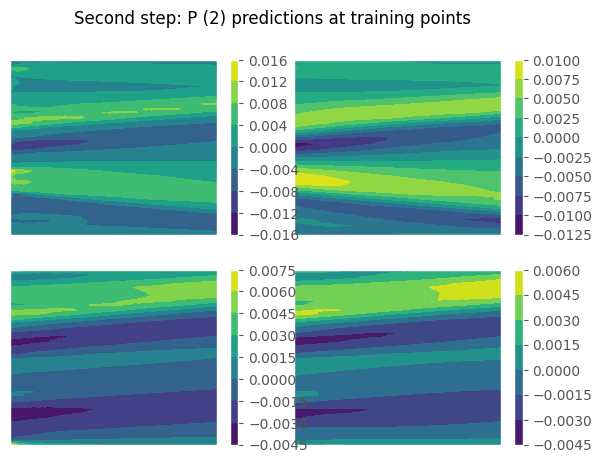

In [23]:
# Plot: P at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,0], X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,1], f_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr].flatten())
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,0], X_gh_tr[i*N_gh_tr:(i+1)*N_gh_tr,1], f_gh_tr_pred[i*N_gh_tr:(i+1)*N_gh_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

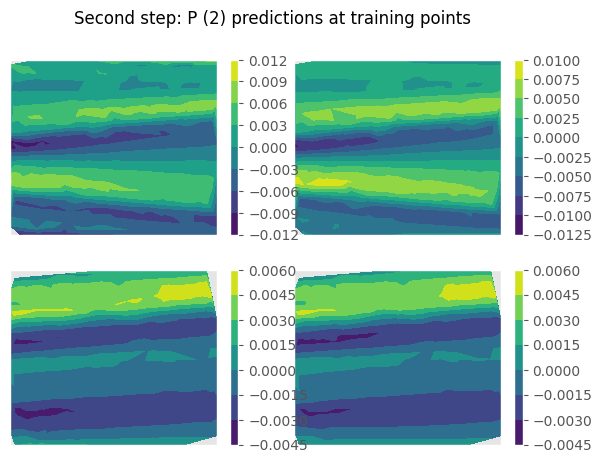

In [24]:
# Plot: P at tr points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 2, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second step: P ({}) predictions at training points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], f_tr2[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_tr[i*N_tr:(i+1)*N_tr,0], X_tr[i*N_tr:(i+1)*N_tr,1], f_tr_pred[i*N_tr:(i+1)*N_tr])
        plt.colorbar(axsi1, ax = axs[i,1])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])

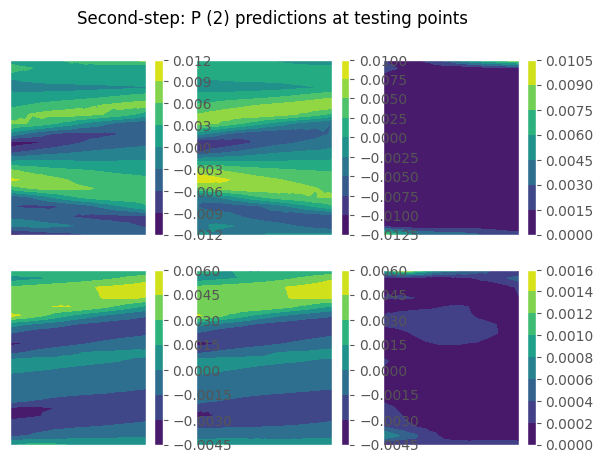

In [25]:
# Plot: P at te points
fig, axs = plt.subplots(figsize = (7,5), nrows = m, ncols = 3, sharex = True, sharey = True)
fig.subplots_adjust(hspace=0.2, wspace=0.1)
fig.suptitle('Second-step: P ({}) predictions at testing points'.format(m))
for i in range(m):
        axsi0 = axs[i,0].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_te2[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi0, ax = axs[i,0])
        axsi1 = axs[i,1].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], f_te_pred[i*N_te:(i+1)*N_te])
        plt.colorbar(axsi1, ax = axs[i,1])
        axsi2 = axs[i,2].tricontourf(X_te[i*N_te:(i+1)*N_te,0], X_te[i*N_te:(i+1)*N_te,1], np.abs(f_te2[i*N_te:(i+1)*N_te]-f_te_pred[i*N_te:(i+1)*N_te]))
        plt.colorbar(axsi2, ax = axs[i,2])
        axs[i,0].set_yticklabels([])
        axs[i,0].set_xticklabels([])
        axs[i,0].set_yticks([])
        axs[i,0].set_xticks([])
        axs[i,1].set_yticklabels([])
        axs[i,1].set_xticklabels([])
        axs[i,1].set_yticks([])
        axs[i,1].set_xticks([])
        axs[i,2].set_yticklabels([])
        axs[i,2].set_xticklabels([])
        axs[i,2].set_yticks([])
        axs[i,2].set_xticks([])

In [26]:
# NMSEs: P at training points and testing points
print('Normalized MSEs between P and P_pred for {} functions'.format(m))
for i in range(m):
    n_mse_train = rel_mse(f_tr2[i*N_tr:(i+1)*N_tr], f_tr_pred[i*N_tr:(i+1)*N_tr])
    n_mse_test = rel_mse(f_te2[i*N_te:(i+1)*N_te], f_te_pred[i*N_te:(i+1)*N_te])
    print('m = {} nmse_train = {}'.format(i,n_mse_train))
    print('m = {} nmse_test = {}'.format(i,n_mse_test))

Normalized MSEs between P and P_pred for 2 functions
m = 0 nmse_train = 0.3019628760776484
m = 0 nmse_test = 0.3455455504717882
m = 1 nmse_train = 0.067022039177884
m = 1 nmse_test = 0.11672750375265384


RKHS norm squared of $P^*$

In [27]:
# rkhs_P
nugget_P = 1e-7
G = K(Gaussian,S_tr_s,S_tr_s, optim_d_P) + nugget_P*np.eye(X_tr.shape[0]) # added nugget here !
alphas_P = np.linalg.solve(G, f_tr_pred)
rkhs_P_train = np.dot(f_tr_pred, alphas_P)
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_train,2)))
# Save true values to be used in one-step
two_step_dict['rkhs_P_train'] = rkhs_P_train
two_step_dict['nugget_P'] = nugget_P

RKHS^s norm of P^*: 0.26


In [28]:
# rkhs_P
nugget_P = 1e-7
G_test = K(Gaussian,S_te_s,S_te_s, optim_d_P) + nugget_P*np.eye(X_te.shape[0]) # added nugget here !
alphas_P_test = np.linalg.solve(G_test, f_te_pred)
rkhs_P_test = np.dot(f_te_pred,alphas_P_test)
two_step_dict['rkhs_P_test'] = rkhs_P_test
print('RKHS^s norm of P^*: {}'.format(round(rkhs_P_test,2)))

RKHS^s norm of P^*: 0.25


In [29]:
two_step_dict['f_gh_tr_pred'] = f_gh_tr_pred

Test

> Compute std of feature 1 $\sigma_{\text{s[:,1]}}$ of `S_tr` and perturb feature 1 of `S_tr` using $m \sigma_{\text{s[:,1]}}$ each element. $m \in (0.01,0.25)$.

In [30]:
# mses_P_all = []
# for j in tqdm(range(5)):
#     # Compute std per feature of S_tr_s
#     stds = np.std(S_tr, axis = 0)
#     beta = np.arange(0.0,0.25,0.05)
#     scales = np.outer(beta, stds) 
#     mses_P = []
#     for i in tqdm(range(len(scales))):
#         # Scales for current iteration
#         scale = scales[i,:]
#         # Copy S_tr
#         S_te = np.copy(S_tr)
#         # Perturb feature that contains u^* - Do this 10 times and average !!!
#         S_te[:,2] = np.random.normal(S_tr[:,2] , scale = scale[2])
#         # Apply step one to perturbed u's 
#         optim_sgm_u, alphas, optim_nugget_u = kernel_parameters_Gaussian_2D(X_tr, U_tr, N_tr)
#         _, _, u_x_pred, u_xx_pred = predictions_Burgers_tr(X_tr, Gaussian2D, optim_sgm_u, alphas, N_tr)
#         S_te[:,3] = u_x_pred.T.reshape(-1,1).flatten()
#         S_te[:,4] = u_xx_pred.T.reshape(-1,1).flatten()
#         # Scale the new S_te
#         S_te_s = scaler_S_tr.transform(S_te)
#         # Compute predictions on test
#         f_te_pred = krr_optimal_P.predict(S_te_s)
#         # True test -> Why if I use this rule for S_te_s the bellow rule cannot be compared with f_te_pred
#         f_true_test = -S_te[:,2]*S_te[:,3] + 0.01*S_te[:,4]
#         # Compute mse per scale 
#         mses_P.append(mean_squared_error(f_true_test,f_te_pred)/mean_squared_error(0*f_true_test,f_true_test))
# # Plot - We have a vector of dimension 4 of scales vs. mses
#     mses_P_all.append(mses_P)
# mses_P_all = np.array(mses_P_all)
# print(mses_P_all)
# mean_mses_P_all = np.mean(mses_P_all, axis = 0)
# plt.plot(beta,mean_mses_P_all,'.-')
# plt.xlabel('noise level: percentage of std of u^*')
# plt.ylabel('mse: f_pred vs. f_true')
# plt.show()

Graph above was generated by using a polynomial kernel for learning P.

In [31]:
np.save('data/two_step_dict.npy',two_step_dict)